## imports

In [37]:
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from collections import Counter
from PIL import Image
from tqdm import tqdm

import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import torchvision.models.detection as detection

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()  

In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [39]:
root = "../../data/FullExpressions/CROHME2019_micro_train_tmp/" #marie

## Pre treatement

### class

In [46]:
class CROHMEDataset(Dataset):
    """
    Dataset pour les expressions complètes (PNG + LG).
    Chaque sample retourne :
        - image : Tensor CxHxW
        - target : dict contenant "boxes" et "labels"
    """

    def __init__(self, root, transform=None, meta_classes=True):
        """
        root : chemin du dossier contenant les PNG + LG
        transform : transform PyTorch (augmentations, ToTensor, Resize…)
        meta_classes : si True, map chaque label vers une méta-classe
        """
        self.root = root
        self.transform = transform
        self.meta_classes = meta_classes

        # liste des fichiers PNG / LG
        self.images = [f for f in os.listdir(root) if f.endswith(".png")]
        self.images.sort()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root, img_name)

        lg_name = img_name.replace(".png", ".lg")
        lg_path = os.path.join(self.root, lg_name)

        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        boxes = []
        labels = []

        with open(lg_path, "r", encoding='utf-8', errors='ignore') as f:
            for line in f:
                parts = [p.strip() for p in line.strip().split(",") if p.strip() != ""]
                if len(parts) < 6:
                    parts = [p.strip() for p in line.strip().split() if p.strip() != ""]
                if len(parts) < 6:
                    continue

                label = parts[1]
                try:
                    last4 = parts[-4:]
                    vals = [float(v) for v in last4]
                except Exception:
                    continue

                # try possible orderings and keep the one that fits image bounds
                candidates = [
                    (vals[0], vals[1], vals[2], vals[3]),  # assume xmin,ymin,xmax,ymax
                    (vals[1], vals[0], vals[3], vals[2]),  # assume ymin,xmin,ymax,xmax (old)
                ]

                chosen = None
                for xmin, ymin, xmax, ymax in candidates:
                    if xmin < xmax and ymin < ymax and 0 <= xmin < xmax <= orig_w and 0 <= ymin < ymax <= orig_h:
                        chosen = (xmin, ymin, xmax, ymax)
                        break

                # if none valid, clamp first candidate and skip if degenerate
                if chosen is None:
                    xmin, ymin, xmax, ymax = candidates[0]
                    xmin = max(0.0, min(xmin, orig_w))
                    xmax = max(0.0, min(xmax, orig_w))
                    ymin = max(0.0, min(ymin, orig_h))
                    ymax = max(0.0, min(ymax, orig_h))
                    if xmax <= xmin or ymax <= ymin:
                        # skip invalid/degenerate box
                        continue
                    chosen = (xmin, ymin, xmax, ymax)

                xmin, ymin, xmax, ymax = chosen

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.map_label(label))

        # Convert to tensors; ensure correct shapes even when empty
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image = self.transform(image)

        return image, target

    def map_label(self, label):
        raw = label.split("_")[0].strip()
        if raw.isalpha():
            return 0

        if raw.isdigit():
            return 1

        if raw in {"+", "-", "=", "/", "*", "×", "÷", "^"}:
            return 2
        return 3

    def raw_label_to_id(self, raw):
        if not hasattr(self, "raw_vocab"):
            self.raw_vocab = {}
        if raw not in self.raw_vocab:
            self.raw_vocab[raw] = len(self.raw_vocab)
        return self.raw_vocab[raw]

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

### visualisation

#### Dataset

In [41]:
dataset = CROHMEDataset(
    root=root,
    transform=transforms.ToTensor(),
    meta_classes=True
)

image, target = dataset[0]
print("Image : ", image.size())
print("Target : ", target)

dataset_len = len(dataset)
train_len = int(0.8 * dataset_len)
val_len = int(0.1 * dataset_len)
test_len = dataset_len - train_len - val_len

train, val, test = torch.utils.data.random_split(
    dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42)
)
print(f"Dataset sizes -> total: {dataset_len}, train: {train_len}, val: {val_len}, test: {test_len}")

Image :  torch.Size([3, 119, 500])
Target :  {'boxes': tensor([[ 10.,  40.,  39., 108.],
        [270.,  46., 320.,  72.],
        [340.,  47., 371.,  71.],
        [467.,  10., 489.,  38.],
        [121.,  38., 166.,  63.],
        [226.,  21., 265.,  65.],
        [399.,  10., 452.,  76.]]), 'labels': tensor([0, 0, 2, 1, 2, 0, 0])}
Dataset sizes -> total: 48, train: 38, val: 4, test: 6


In [42]:
batch_size = 3
# Use the Subset objects created earlier by random_split: `train`, `val`, `test`.
# If `train` or `val` don't exist yet (cell not executed), compute splits here as a fallback.
try:
    train_subset = train
    val_subset = val
except NameError:
    dataset_len = len(dataset)
    # train_len = int(0.8 * dataset_len)
    # val_len = int(0.1 * dataset_len)
    # test_len = dataset_len - train_len - val_len
    train_len = 100
    val_len = 100
    test_len = 20
    train_subset, val_subset, _ = torch.utils.data.random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


#### Fct

In [43]:
# ...existing code...
def show_raw_boxes(dataset, idx=None):
    """
    Affiche les bounding boxes "brutes" et les labels pour un sample (ou un index aléatoire).
    Ne montre pas l'image, ne formate pas les boîtes — imprime juste les valeurs.
    """
    import random
    from torch.utils.data import Subset as TorchSubset

    if idx is None:
        # choisir un index aléatoire dans le dataset/subset
        if isinstance(dataset, TorchSubset):
            n = len(dataset)
        else:
            n = len(dataset)
        idx = random.randrange(n)

    # gérer Subset
    if isinstance(dataset, TorchSubset):
        base = dataset.dataset
        real_idx = dataset.indices[idx]
    else:
        base = dataset
        real_idx = idx

    _, target = base[real_idx]
    boxes = target.get("boxes", None)
    labels = target.get("labels", None)

    # Affichage "brut"
    print(f"dataset index (subset idx) = {idx}, real index = {real_idx}")
    print("boxes (raw):")
    if boxes is None:
        print(None)
    else:
        try:
            # si tensor -> list
            if hasattr(boxes, "tolist"):
                print(boxes.tolist())
            else:
                print(boxes)
        except Exception:
            print(repr(boxes))

    print("labels (raw):")
    if labels is None:
        print(None)
    else:
        try:
            if hasattr(labels, "tolist"):
                print(labels.tolist())
            else:
                print(labels)
        except Exception:
            print(repr(labels))

    return boxes, labels

# Exemple d'utilisation (décommentez pour tester):
show_raw_boxes(dataset, 0)
show_raw_boxes(train_subset)  # index aléatoire dans le subset


dataset index (subset idx) = 0, real index = 0
boxes (raw):
[[10.0, 40.0, 39.0, 108.0], [270.0, 46.0, 320.0, 72.0], [340.0, 47.0, 371.0, 71.0], [467.0, 10.0, 489.0, 38.0], [121.0, 38.0, 166.0, 63.0], [226.0, 21.0, 265.0, 65.0], [399.0, 10.0, 452.0, 76.0]]
labels (raw):
[0, 0, 2, 1, 2, 0, 0]
dataset index (subset idx) = 16, real index = 19
boxes (raw):
[[18.0, 15.0, 37.0, 52.0], [77.0, 37.0, 89.0, 61.0], [89.0, 55.0, 97.0, 69.0], [105.0, 37.0, 119.0, 58.0], [118.0, 26.0, 128.0, 71.0], [226.0, 15.0, 241.0, 47.0], [250.0, 23.0, 261.0, 43.0], [232.0, 55.0, 248.0, 81.0], [270.0, 46.0, 277.0, 60.0], [289.0, 28.0, 302.0, 56.0], [406.0, 51.0, 413.0, 65.0], [430.0, 15.0, 446.0, 51.0], [450.0, 29.0, 466.0, 50.0], [431.0, 65.0, 447.0, 90.0], [480.0, 10.0, 489.0, 97.0], [10.0, 55.0, 44.0, 58.0], [225.0, 52.0, 263.0, 56.0], [424.0, 60.0, 459.0, 62.0], [15.0, 55.0, 36.0, 83.0], [34.0, 60.0, 46.0, 81.0], [57.0, 34.0, 68.0, 70.0], [196.0, 20.0, 209.0, 91.0], [360.0, 20.0, 371.0, 103.0], [145.0, 40.0, 

(tensor([[ 18.,  15.,  37.,  52.],
         [ 77.,  37.,  89.,  61.],
         [ 89.,  55.,  97.,  69.],
         [105.,  37., 119.,  58.],
         [118.,  26., 128.,  71.],
         [226.,  15., 241.,  47.],
         [250.,  23., 261.,  43.],
         [232.,  55., 248.,  81.],
         [270.,  46., 277.,  60.],
         [289.,  28., 302.,  56.],
         [406.,  51., 413.,  65.],
         [430.,  15., 446.,  51.],
         [450.,  29., 466.,  50.],
         [431.,  65., 447.,  90.],
         [480.,  10., 489.,  97.],
         [ 10.,  55.,  44.,  58.],
         [225.,  52., 263.,  56.],
         [424.,  60., 459.,  62.],
         [ 15.,  55.,  36.,  83.],
         [ 34.,  60.,  46.,  81.],
         [ 57.,  34.,  68.,  70.],
         [196.,  20., 209.,  91.],
         [360.,  20., 371., 103.],
         [145.,  40., 166.,  50.],
         [254.,  59., 264.,  75.],
         [303.,  16., 311.,  93.],
         [331.,  42., 345.,  57.],
         [386.,  32., 401.,  60.],
         [450.,  66.

In [44]:
import random
from torch.utils.data import Subset as TorchSubset
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_image_with_boxes_debug(dataset, idx: int):
    """Debug: print sizes, raw boxes and scaled boxes; draw all boxes with indices."""
    

    # handle Subset
    if isinstance(dataset, TorchSubset):
        base = dataset.dataset
        real_idx = dataset.indices[idx]
    else:
        base = dataset
        real_idx = idx

    sample_image, target = base[real_idx]
    # ensure tensor
    if not isinstance(sample_image, torch.Tensor):
        sample_image = transforms.ToTensor()(sample_image)

    img_name = base.images[real_idx]
    img_path = os.path.join(base.root, img_name)
    with Image.open(img_path) as pil:
        orig_w, orig_h = pil.size

    _, h, w = sample_image.shape
    print(f"real_idx={real_idx} orig_w,orig_h=({orig_w},{orig_h}) tensor_w,h=({w},{h})")

    boxes = target.get("boxes", torch.zeros((0,4)))
    labels = target.get("labels", None)
    print("raw boxes:", boxes if not hasattr(boxes, "tolist") else boxes.tolist())
    if labels is not None:
        print("raw labels:", labels.tolist() if hasattr(labels, "tolist") else labels)

    # Ensure tensor
    if isinstance(boxes, list):
        boxes = torch.tensor(boxes, dtype=torch.float32)
    boxes_scaled = boxes.clone()
    if boxes_scaled.numel() > 0:
        scale_x = w / orig_w if orig_w>0 else 1.0
        scale_y = h / orig_h if orig_h>0 else 1.0
        boxes_scaled[:, [0,2]] *= scale_x
        boxes_scaled[:, [1,3]] *= scale_y

    print("scaled boxes:", boxes_scaled.tolist() if hasattr(boxes_scaled, "tolist") else boxes_scaled)

    # clip to image and report which boxes become invalid/empty
    boxes_clipped = boxes_scaled.clone()
    if boxes_clipped.numel() > 0:
        boxes_clipped[:, 0] = boxes_clipped[:, 0].clamp(min=0, max=w)
        boxes_clipped[:, 2] = boxes_clipped[:, 2].clamp(min=0, max=w)
        boxes_clipped[:, 1] = boxes_clipped[:, 1].clamp(min=0, max=h)
        boxes_clipped[:, 3] = boxes_clipped[:, 3].clamp(min=0, max=h)
        areas = (boxes_clipped[:,2]-boxes_clipped[:,0]).clamp(min=0) * (boxes_clipped[:,3]-boxes_clipped[:,1]).clamp(min=0)
        for i, a in enumerate(areas.tolist()):
            print(f"box {i} area after clipping = {a:.1f}")

    # draw
    npimg = sample_image.numpy().transpose(1,2,0)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(npimg)
    cmap = plt.get_cmap("tab10")
    for i, box in enumerate(boxes_clipped if boxes_clipped.numel()>0 else torch.zeros((0,4))):
        xmin, ymin, xmax, ymax = [float(x) for x in box]
        color = cmap(i % 10)
        rect = mpl.patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin-6, f"{i}", color=color, fontsize=10, weight="bold", backgroundcolor="white")
    ax.axis("off")
    plt.show()
    return {"orig_size": (orig_w, orig_h), "tensor_size": (w,h), "raw_boxes": boxes, "scaled": boxes_scaled, "clipped": boxes_clipped}


#### Viz

dataset index (subset idx) = 0, real index = 0
boxes (raw):
[[10.0, 40.0, 39.0, 108.0], [270.0, 46.0, 320.0, 72.0], [340.0, 47.0, 371.0, 71.0], [467.0, 10.0, 489.0, 38.0], [121.0, 38.0, 166.0, 63.0], [226.0, 21.0, 265.0, 65.0], [399.0, 10.0, 452.0, 76.0]]
labels (raw):
[0, 0, 2, 1, 2, 0, 0]
real_idx=0 orig_w,orig_h=(500,119) tensor_w,h=(500,119)
raw boxes: [[10.0, 40.0, 39.0, 108.0], [270.0, 46.0, 320.0, 72.0], [340.0, 47.0, 371.0, 71.0], [467.0, 10.0, 489.0, 38.0], [121.0, 38.0, 166.0, 63.0], [226.0, 21.0, 265.0, 65.0], [399.0, 10.0, 452.0, 76.0]]
raw labels: [0, 0, 2, 1, 2, 0, 0]
scaled boxes: [[10.0, 40.0, 39.0, 108.0], [270.0, 46.0, 320.0, 72.0], [340.0, 47.0, 371.0, 71.0], [467.0, 10.0, 489.0, 38.0], [121.0, 38.0, 166.0, 63.0], [226.0, 21.0, 265.0, 65.0], [399.0, 10.0, 452.0, 76.0]]
box 0 area after clipping = 1972.0
box 1 area after clipping = 1300.0
box 2 area after clipping = 744.0
box 3 area after clipping = 616.0
box 4 area after clipping = 1125.0
box 5 area after clipping = 

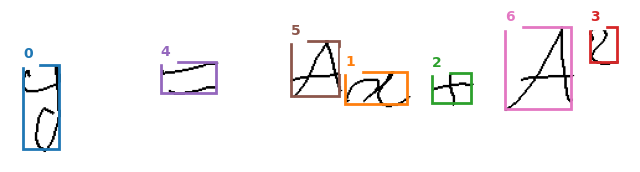

Test sur dataset[0]
Erreur sur dataset: show_image_with_boxes_debug() got an unexpected keyword argument 'show'
Test sur train_subset[0]
Erreur sur train_subset: show_image_with_boxes_debug() got an unexpected keyword argument 'show'


In [45]:
show_raw_boxes(dataset, 0)
show_image_with_boxes_debug(dataset, 0)


# ...existing code...
# Cellule de test pour show_image_with_boxes
try:
    print("Test sur dataset[0]")
    show_image_with_boxes_debug(dataset, 0, show=True)
except Exception as e:
    print("Erreur sur dataset:", e)

# Si vous utilisez un Subset (train_subset), tester aussi :
try:
    print("Test sur train_subset[0]")
    show_image_with_boxes_debug(train_subset, 0, show=True)
except Exception as e:
    print("Erreur sur train_subset:", e)
# ...existing code...

## Baseline

### Class

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader

class NetMLP(nn.Module):
    def __init__(self, hiddencells=100, out_classes=5):
        super(NetMLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32, hiddencells)
        self.fc2 = nn.Linear(hiddencells, out_classes)
    def forward(self, x):
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # logits for CrossEntropyLoss

# transform for MLP (32x32 grayscale)
mlp_transform = T.Compose([
    T.Resize((32, 32)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor()
])


### Data

In [65]:
# small dataset for quick test (use full dataset if desired)
dataset_mlp = CROHMEDataset(root=root, transform=mlp_transform, meta_classes=True)

# split
n = len(dataset_mlp)
train_n = int(0.8 * n)
val_n = int(0.1 * n)
test_n = n - train_n - val_n
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset_mlp, [train_n, val_n, test_n], generator=torch.Generator().manual_seed(42))

def collate_for_mlp(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)            # (B, C, H, W)
    labels = []
    for t in targets:
        labs = t.get("labels", None)
        if labs is None or len(labs) == 0:
            labels.append(0)
        else:
            v = labs[0]
            labels.append(int(v.item()) if torch.is_tensor(v) else int(v))
    labels = torch.tensor(labels, dtype=torch.long)
    return images, labels

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_for_mlp, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate_for_mlp, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, collate_fn=collate_for_mlp, num_workers=0)



### Loop

Epoch 1 of 20 took 0.176s
Epoch 2 of 20 took 0.079s
Epoch 3 batch     1 
Train loss : 0.047
Validation loss mean : 0.285
Epoch 3 of 20 took 0.078s
Epoch 4 of 20 took 0.085s
Epoch 5 batch     2 
Train loss : 0.032
Validation loss mean : 0.204
Epoch 5 of 20 took 0.081s
Epoch 6 of 20 took 0.052s
Epoch 7 of 20 took 0.061s
Epoch 8 batch     1 
Train loss : 0.033
Validation loss mean : 0.189
Epoch 8 of 20 took 0.077s
Epoch 9 of 20 took 0.079s
Epoch 10 batch     2 
Train loss : 0.031
Validation loss mean : 0.178
Epoch 10 of 20 took 0.066s
Epoch 11 of 20 took 0.070s
Epoch 12 of 20 took 0.054s
Epoch 13 batch     1 
Train loss : 0.031
Validation loss mean : 0.199
Epoch 13 of 20 took 0.076s
Epoch 14 of 20 took 0.060s
Epoch 15 batch     2 
Train loss : 0.032
Validation loss mean : 0.226
Epoch 15 of 20 took 0.081s
Epoch 16 of 20 took 0.053s
Epoch 17 of 20 took 0.063s
Epoch 18 batch     1 
Train loss : 0.031
Validation loss mean : 0.202
Epoch 18 of 20 took 0.092s
Epoch 19 of 20 took 0.075s
Epoch 20 

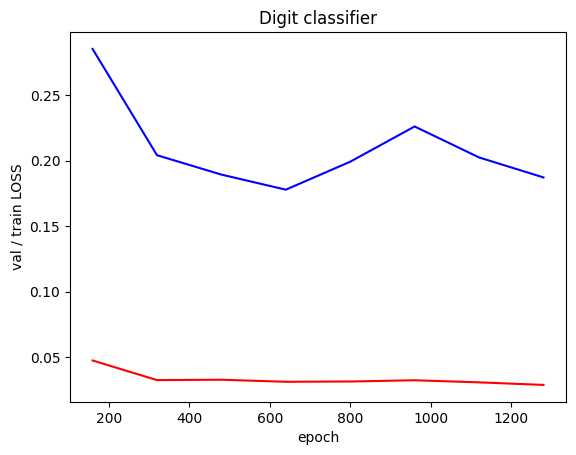

In [60]:
import copy
import time

model = NetMLP(hiddencells=100, out_classes=5)  # 4 meta-classes
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)




# Definition of arrays to store the results and draw the learning curves
val_err_array = np.array([])
train_err_array = np.array([])
nb_sample_array = np.array([])

# best system results
best_val_loss = 1000000
best_nb_sample = 0
best_model =  copy.deepcopy(model)

nb_used_sample = 0
running_loss = 0.0
num_epochs = 20
print_every = 5
#print_every = 1000

for epoch in range(num_epochs):  # loop over the dataset multiple times
    start_time = time.time()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # if possible, move them to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # count how many samples have been used during the training
        nb_used_sample += batch_size
        # print/save statistics
        running_loss += loss.item()
        if nb_used_sample % (print_every * batch_size) == 0:    # print every ""print_every"" mini-batches
            train_err = (running_loss / (print_every * batch_size))
            print('Epoch %d batch %5d ' % (epoch + 1, i + 1))
            print('Train loss : %.3f' % train_err)
            running_loss = 0.0
            #evaluation on validation set
            totalValLoss = 0.0
            with torch.no_grad():
                for data in val_loader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    totalValLoss += loss.item()
            val_err = (totalValLoss / len(val_ds))
            print('Validation loss mean : %.3f' % val_err)
            train_err_array = np.append(train_err_array, train_err)
            val_err_array = np.append(val_err_array, val_err)
            nb_sample_array = np.append(nb_sample_array, nb_used_sample)

            # save the model only when loss is better
            best_model =  copy.deepcopy(model)
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))

print('Finished Training')

### save the best model :
#torch.save(best_model.state_dict(), "./best_model_q1.nn")

plt.clf()
plt.xlabel('epoch')
plt.ylabel('val / train LOSS')
plt.title('Digit classifier')
plt.plot(nb_sample_array.tolist(), val_err_array.tolist(), 'b',nb_sample_array.tolist(), train_err_array.tolist(), 'r')#, [best_nb_sample], [best_val_loss],         'go')
plt.show()


Epoch 1 finished in 0.1s
Epoch 2 finished in 0.1s
Epoch 3 finished in 0.1s
Epoch 4 finished in 0.1s
Epoch 5 finished in 0.1s
Epoch 6 finished in 0.1s
Epoch 7 finished in 0.1s
Epoch 8 finished in 0.1s
Epoch 9 finished in 0.1s
Epoch 10 finished in 0.1s
Epoch 11 finished in 0.1s
Epoch 12 finished in 0.1s
Epoch 13 finished in 0.1s
Epoch 14 finished in 0.1s
Epoch 15 finished in 0.1s
All epochs done (1.1s). Best val loss: inf


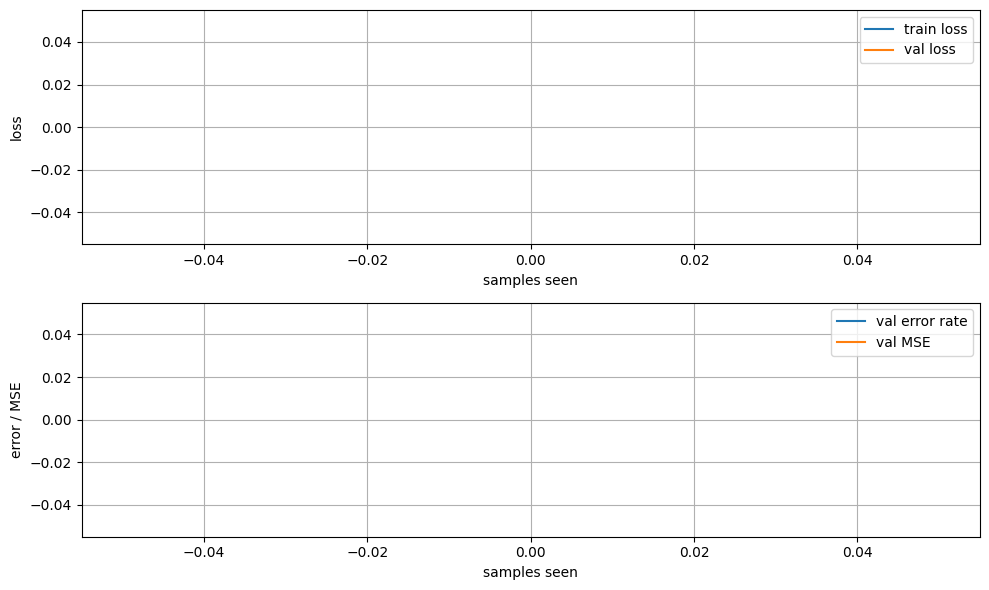

In [ ]:

# model / loss / optimizer
num_classes = 5  # adjust if different
model = NetMLP(hiddencells=128, out_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)



# Definition of arrays to store the results and draw the learning curves
val_err_array = np.array([])
train_err_array = np.array([])
nb_sample_array = np.array([])




# quick training loop (few epochs)
epochs = 5
for epoch in range(epochs):
    model.train()
    running = 0.0
    batches = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running += loss.item()
        batches += 1
        # optional: limit iterations for speed
        if batches >= 200:
            break
    train_loss = running / max(1, batches)

    # validation
    model.eval()
    vloss = 0.0
    vb = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            vloss += loss.item()
            vb += 1
            if vb >= 50:
                break
    val_loss = vloss / max(1, vb)

    print(f"Epoch {epoch+1}/{epochs}  Train loss: {train_loss:.4f}  Val loss: {val_loss:.4f}")

# save quick checkpoint
#torch.save(model.state_dict(), "mlp_quick_test.pth")

In [62]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
from sklearn.metrics import confusion_matrix


def fullTraining(net,
                 trainloader,
                 validationloader,
                 validationset,
                 optimizer,
                 criterion = nn.CrossEntropyLoss(),
                 minibatchsize = 3,
                 num_epochs = 5,
                 print_every = 10,
                 print_epoch = True,
                 savename = ''):
    """Entraîne le réseau de neurones en entrée sur les datasets d'entraînement et de validation"""

    # Definition of arrays to store the results and draw the learning curves
    val_err_array = np.array([])
    train_err_array = np.array([])
    nb_sample_array = np.array([])

    # best system results
    best_val_loss = 1000000
    best_nb_sample = 0
    running_loss = 0.0
    best_model =  copy.deepcopy(net)

    nb_used_sample = 0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # if possible, move them to GPU

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # count how many samples have been used during the training
            nb_used_sample += minibatchsize
            # print/save statistics
            running_loss += loss.item()
            if nb_used_sample % (print_every * minibatchsize) == 0:    # print every ""print_every"" mini-batches
                train_err = (running_loss / (print_every * minibatchsize))
                print('Epoch %d batch %5d ' % (epoch + 1, i + 1))
                print('Train loss : %.3f' % train_err)
                running_loss = 0.0
                #evaluation on validation set
                totalValLoss = 0.0
                with torch.no_grad():
                    for data in validationloader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criterion(outputs, labels)
                        totalValLoss += loss.item()
                val_err = (totalValLoss / len(validationset))
                print('Validation loss mean : %.3f' % val_err)
                train_err_array = np.append(train_err_array, train_err)
                val_err_array = np.append(val_err_array, val_err)
                nb_sample_array = np.append(nb_sample_array, nb_used_sample)

                # save the model only when loss is better
                best_model =  copy.deepcopy(net)
        if print_epoch :
            print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))

    print('Finished Training')

    # save the best model
    if savename != '':
        torch.save(best_model.state_dict(), f"./best_model_{savename}.nn")

    # learning curves
    fig, ax = plt.subplots()
    ax.set_xlabel('epoch')
    ax.set_ylabel('val (blue)/ train (red) LOSS')
    ax.set_title('Digit classifier')
    ax.plot(nb_sample_array.tolist(), val_err_array.tolist(), 'b', nb_sample_array.tolist(), train_err_array.tolist(), 'r')

    # trained network
    return best_model, fig




""" Question 2 :
Define also a function that takes the trained network
and returns the accuracy of the network on the test set.
"""

def accuracy_test(net,
                  testloader,
                  minibatchsize = 32,
                  nb_classes = 5,
                  classes = ['alpha', 'digit', 'operator', 'other', 'background'],
                  print_acc = False,
                  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")) :
    """Teste le réseau de neurones sur le dataset de test, puis calcule son accuracy globale et pour chaque classe"""
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Check the results for each class
    class_correct = list(0. for i in range(nb_classes))
    class_total = list(0. for i in range(nb_classes))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


            # garder pour la matrice
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if print_acc :
        print('Accuracy of the network on the test images: %3.2f %%' % (100.0 * correct / total))
        for i in range(nb_classes):
            if class_total[i] > 0 :
                print('Accuracy of %5s : %3.2f %% (%d/%d)' % (
                    classes[i], 100.0 * class_correct[i] / class_total[i], class_correct[i] , class_total[i]))
            else:
                print('No %5s sample' % (classes[i]))

    return correct, total, class_correct, class_total, all_preds, all_labels

def print_matrix(all_labels, all_preds, classes):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=classes, yticklabels=classes, cbar=False)
    plt.xlabel("Predictions")
    plt.ylabel("Ground Truth")
    plt.title("Confusion matrix")
    plt.show()

----- Initialisation of the neural network -----
----- Training of the neural network -----
Epoch 1 of 5 took 0.108s
Epoch 2 of 5 took 0.054s
Epoch 3 of 5 took 0.050s
Epoch 4 of 5 took 0.071s
Epoch 5 batch     2 
Train loss : 0.249
Validation loss mean : 0.200
Epoch 5 of 5 took 0.075s
Finished Training


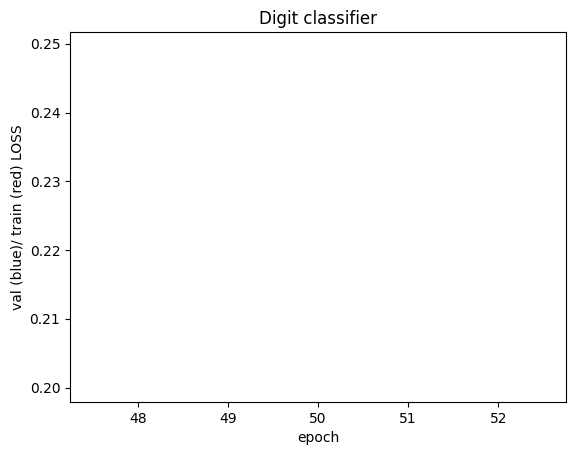

----- Evaluation of the neural network on the test set -----
Accuracy of the network on the test images: 66.67 %
Accuracy of alpha : 100.00 % (4/4)
No digit sample
No operator sample
Accuracy of other : 0.00 % (0/2)
No background sample


In [66]:



##### Neural network #####

print("----- Initialisation of the neural network -----")
net = NetMLP(100)
net.to(device) # move it to GPU or CPU

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.01)




##### Training #####

print("----- Training of the neural network -----")
best_model, fig = fullTraining(
    net,
    train_loader,
    val_loader,
    val_ds,
    optimizer,
    criterion,
    minibatchsize = 5,
    num_epochs = 5,
    print_every = 10,
    print_epoch = True,
    savename = 'mlp_crohme')

display(fig)
plt.close(fig)




##### Test of the trained neural network #####

print("----- Evaluation of the neural network on the test set -----")
correct, total, class_correct, class_total, all_preds, all_labels = accuracy_test(
    net,
    test_loader,
    minibatchsize = 32,
    print_acc = True,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))




## FasterNN